In [1]:
import requests
from config import API_KEY
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

## Get Data from eia API

In [2]:
eastCoast = f"http://api.eia.gov/series/?api_key={API_KEY}&series_id=PET.EMM_EPM0_PTE_R10_DPG.W"
midwest = f"http://api.eia.gov/series/?api_key={API_KEY}&series_id=PET.EMM_EPM0_PTE_R20_DPG.W"
gulfCoast = f"http://api.eia.gov/series/?api_key={API_KEY}&series_id=PET.EMM_EPM0_PTE_R30_DPG.W"
rockyMountain = f"http://api.eia.gov/series/?api_key={API_KEY}&series_id=PET.EMM_EPM0_PTE_R40_DPG.W"
westCoast = f"http://api.eia.gov/series/?api_key={API_KEY}&series_id=PET.EMM_EPM0_PTE_R50_DPG.W"

In [3]:
eastCoast_df = pd.DataFrame(requests.get(eastCoast).json()['series'][0]['data'])
midwest_df = pd.DataFrame(requests.get(midwest).json()['series'][0]['data'])
gulfCoast_df = pd.DataFrame(requests.get(gulfCoast).json()['series'][0]['data'])
rockyMountain_df = pd.DataFrame(requests.get(rockyMountain).json()['series'][0]['data'])
westCoast_df = pd.DataFrame(requests.get(westCoast).json()['series'][0]['data'])

In [4]:
eastCoast_df.rename(columns = {0:"week", 1:"price_eastCoast"}, inplace = True)
midwest_df.rename(columns = {0:"week", 1:"price_midwest"}, inplace = True)
gulfCoast_df.rename(columns = {0:"week", 1:"price_gulfCoast"}, inplace = True)
rockyMountain_df.rename(columns = {0:"week", 1:"price_rockyMountain"}, inplace = True)
westCoast_df.rename(columns = {0:"week", 1:"price_westCoast"}, inplace = True)

In [5]:
eastCoast_df['week'] = pd.to_datetime(eastCoast_df['week'])
midwest_df['week'] = pd.to_datetime(midwest_df['week'])
gulfCoast_df['week'] = pd.to_datetime(gulfCoast_df['week'])
rockyMountain_df['week'] = pd.to_datetime(rockyMountain_df['week'])
westCoast_df['week'] = pd.to_datetime(westCoast_df['week'])

In [6]:
prices_df = eastCoast_df.merge(midwest_df , on = "week", suffixes=('', ''))\
            .merge(gulfCoast_df , on = "week", suffixes=('', ''))\
            .merge(rockyMountain_df , on = "week", suffixes=('', ''))\
            .merge(westCoast_df , on = "week", suffixes=('', ''))

In [7]:
regions = ["eastCoast", "midwest", "gulfCoast", "rockyMountain", "westCoast"]
for region in regions:
    prices_df['change_' + region] = prices_df['price_' + region].diff()

In [8]:
prices_df

,week,price_eastCoast,price_midwest,price_gulfCoast,price_rockyMountain,price_westCoast,change_eastCoast,change_midwest,change_gulfCoast,change_rockyMountain,change_westCoast
0,2020-11-09,2.127,2.025,1.823,2.304,2.863,NaN,NaN,NaN,NaN,NaN
1,2020-11-02,2.149,2.026,1.862,2.320,2.869,0.022,0.001,0.039,0.016,0.006
2,2020-10-26,2.173,2.069,1.908,2.340,2.882,0.024,0.043,0.046,0.020,0.013
3,2020-10-19,2.196,2.057,1.905,2.359,2.887,0.023,-0.012,-0.003,0.019,0.005
4,2020-10-12,2.209,2.089,1.914,2.367,2.895,0.013,0.032,0.009,0.008,0.008
...,...,...,...,...,...,...,...,...,...,...,...
1436,1993-05-03,1.062,1.073,1.084,1.161,1.161,-0.007,-0.018,-0.004,0.018,-0.010
1437,1993-04-26,1.059,1.078,1.081,1.169,1.157,-0.003,0.005,-0.003,0.008,-0.004
1438,1993-04-19,1.054,1.067,1.081,1.120,1.155,-0.005,-0.011,0.000,-0.049,-0.002
1439,1993-04-12,1.047,1.077,1.071,1.118,1.154,-0.007,0.010,-0.010,-0.002,-0.001


In [9]:
prices_df.dropna(inplace =True)

<AxesSubplot:xlabel='week'>

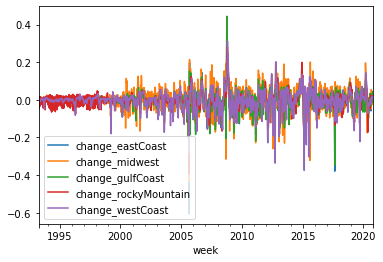

In [10]:
prices_df.plot(x = 'week', y=["change_eastCoast", "change_midwest", "change_gulfCoast", "change_rockyMountain", "change_westCoast"])

### Add in WTI spot price

In [11]:
WTI = f"http://api.eia.gov/series/?api_key={API_KEY}&series_id=PET.RWTC.W"

In [12]:
WTI_df = pd.DataFrame(requests.get(WTI).json()['series'][0]['data'])

In [13]:
WTI_df.rename(columns = {0:"week", 1:"WTI_spotPrice"}, inplace = True)

In [14]:
WTI_df['week'] = pd.to_datetime(WTI_df['week']) + datetime.timedelta(days = 3)

In [15]:
WTI_df ['change_WTI'] = WTI_df['WTI_spotPrice'].diff()

In [16]:
#normalize WTI_change so that it is about the size of gas Price changes (100 is somewhat arbitrary)
WTI_df ['change_WTI_normalized'] = WTI_df ['change_WTI'] / 100

In [17]:
combined_df = prices_df.merge(WTI_df, on = 'week', suffixes=("",""))

### Add in Import/ Export

In [18]:
petroleum_export = f"http://api.eia.gov/series/?api_key={API_KEY}&series_id=PET.WTTEXUS2.W"
petroleum_import = f"http://api.eia.gov/series/?api_key={API_KEY}&series_id=PET.WTTIMUS2.W"

In [19]:
export_df = pd.DataFrame(requests.get(petroleum_export).json()['series'][0]['data'])
import_df = pd.DataFrame(requests.get(petroleum_import).json()['series'][0]['data'])

In [20]:
export_df.rename(columns = {0:"week", 1:"export_barrels"}, inplace = True)
import_df.rename(columns = {0:"week", 1:"import_barrels"}, inplace = True)

In [21]:
export_df['week'] = pd.to_datetime(eastCoast_df['week'])
import_df['week'] = pd.to_datetime(midwest_df['week'])

In [22]:
#niormalize number of import/export barrels (1000000 is somehwat arbitrary)
export_df['export_barrels_normalized'] = export_df['export_barrels']/100000
import_df['import_barrels_normalized'] = import_df['import_barrels']/100000

In [23]:
combined_df = combined_df.merge(export_df, on = 'week', suffixes=("",""))\
          .merge(import_df, on = 'week', suffixes=("",""))

In [24]:
combined_df

,week,price_eastCoast,price_midwest,price_gulfCoast,price_rockyMountain,price_westCoast,change_eastCoast,change_midwest,change_gulfCoast,change_rockyMountain,change_westCoast,WTI_spotPrice,change_WTI,change_WTI_normalized,export_barrels,export_barrels_normalized,import_barrels,import_barrels_normalized
0,2020-11-02,2.149,2.026,1.862,2.320,2.869,0.022,0.001,0.039,0.016,0.006,37.32,-0.39,-0.0039,7568,0.07568,6767,0.06767
1,2020-10-26,2.173,2.069,1.908,2.340,2.882,0.024,0.043,0.046,0.020,0.013,40.43,3.11,0.0311,8082,0.08082,7966,0.07966
2,2020-10-19,2.196,2.057,1.905,2.359,2.887,0.023,-0.012,-0.003,0.019,0.005,40.33,-0.10,-0.0010,8028,0.08028,6968,0.06968
3,2020-10-12,2.209,2.089,1.914,2.367,2.895,0.013,0.032,0.009,0.008,0.008,40.19,-0.14,-0.0014,7525,0.07525,7321,0.07321
4,2020-10-05,2.208,2.106,1.901,2.376,2.903,-0.001,0.017,-0.013,0.009,0.008,38.99,-1.20,-0.0120,7899,0.07899,7889,0.07889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,1993-05-03,1.062,1.073,1.084,1.161,1.161,-0.007,-0.018,-0.004,0.018,-0.010,20.30,-0.17,-0.0017,981,0.00981,9418,0.09418
1436,1993-04-26,1.059,1.078,1.081,1.169,1.157,-0.003,0.005,-0.003,0.008,-0.004,19.95,-0.35,-0.0035,986,0.00986,8715,0.08715
1437,1993-04-19,1.054,1.067,1.081,1.120,1.155,-0.005,-0.011,0.000,-0.049,-0.002,20.28,0.33,0.0033,986,0.00986,7976,0.07976
1438,1993-04-12,1.047,1.077,1.071,1.118,1.154,-0.007,0.010,-0.010,-0.002,-0.001,20.37,0.09,0.0009,986,0.00986,8956,0.08956


## Processs the data

In [25]:
#train test split
train_size = int(0.8 * len(prices_df))
combined_df_train = combined_df.iloc[0:train_size]
combined_df_test = combined_df.iloc[train_size:]

In [26]:
combined_df_train

,week,price_eastCoast,price_midwest,price_gulfCoast,price_rockyMountain,price_westCoast,change_eastCoast,change_midwest,change_gulfCoast,change_rockyMountain,change_westCoast,WTI_spotPrice,change_WTI,change_WTI_normalized,export_barrels,export_barrels_normalized,import_barrels,import_barrels_normalized
0,2020-11-02,2.149,2.026,1.862,2.320,2.869,0.022,0.001,0.039,0.016,0.006,37.32,-0.39,-0.0039,7568,0.07568,6767,0.06767
1,2020-10-26,2.173,2.069,1.908,2.340,2.882,0.024,0.043,0.046,0.020,0.013,40.43,3.11,0.0311,8082,0.08082,7966,0.07966
2,2020-10-19,2.196,2.057,1.905,2.359,2.887,0.023,-0.012,-0.003,0.019,0.005,40.33,-0.10,-0.0010,8028,0.08028,6968,0.06968
3,2020-10-12,2.209,2.089,1.914,2.367,2.895,0.013,0.032,0.009,0.008,0.008,40.19,-0.14,-0.0014,7525,0.07525,7321,0.07321
4,2020-10-05,2.208,2.106,1.901,2.376,2.903,-0.001,0.017,-0.013,0.009,0.008,38.99,-1.20,-0.0120,7899,0.07899,7889,0.07889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,1998-11-09,1.038,1.026,0.998,1.120,1.169,0.007,0.026,0.007,-0.021,0.000,14.13,0.50,0.0050,985,0.00985,10455,0.10455
1148,1998-11-02,1.040,1.025,1.002,1.128,1.172,0.002,-0.001,0.004,0.008,0.003,14.34,0.21,0.0021,1010,0.01010,10363,0.10363
1149,1998-10-26,1.041,1.032,1.007,1.136,1.175,0.001,0.007,0.005,0.008,0.003,13.81,-0.53,-0.0053,1010,0.01010,9982,0.09982
1150,1998-10-19,1.044,1.038,1.014,1.138,1.174,0.003,0.006,0.007,0.002,-0.001,14.21,0.40,0.0040,1010,0.01010,9944,0.09944


In [27]:
combined_df_test

,week,price_eastCoast,price_midwest,price_gulfCoast,price_rockyMountain,price_westCoast,change_eastCoast,change_midwest,change_gulfCoast,change_rockyMountain,change_westCoast,WTI_spotPrice,change_WTI,change_WTI_normalized,export_barrels,export_barrels_normalized,import_barrels,import_barrels_normalized
1152,1998-10-05,1.034,1.050,1.003,1.130,1.182,-0.012,0.005,-0.012,-0.018,0.004,15.83,0.81,0.0081,1010,0.01010,10169,0.10169
1153,1998-09-28,1.029,1.041,0.995,1.135,1.187,-0.005,-0.009,-0.008,0.005,0.005,15.78,-0.05,-0.0005,982,0.00982,10900,0.10900
1154,1998-09-21,1.023,1.047,0.989,1.149,1.189,-0.006,0.006,-0.006,0.014,0.002,14.88,-0.90,-0.0090,982,0.00982,9405,0.09405
1155,1998-09-14,1.024,1.020,0.989,1.152,1.171,0.001,-0.027,0.000,0.003,-0.018,14.45,-0.43,-0.0043,982,0.00982,10455,0.10455
1156,1998-09-07,1.028,1.027,0.989,1.136,1.179,0.004,0.007,0.000,-0.016,0.008,13.98,-0.47,-0.0047,982,0.00982,10054,0.10054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,1993-05-03,1.062,1.073,1.084,1.161,1.161,-0.007,-0.018,-0.004,0.018,-0.010,20.30,-0.17,-0.0017,981,0.00981,9418,0.09418
1436,1993-04-26,1.059,1.078,1.081,1.169,1.157,-0.003,0.005,-0.003,0.008,-0.004,19.95,-0.35,-0.0035,986,0.00986,8715,0.08715
1437,1993-04-19,1.054,1.067,1.081,1.120,1.155,-0.005,-0.011,0.000,-0.049,-0.002,20.28,0.33,0.0033,986,0.00986,7976,0.07976
1438,1993-04-12,1.047,1.077,1.071,1.118,1.154,-0.007,0.010,-0.010,-0.002,-0.001,20.37,0.09,0.0009,986,0.00986,8956,0.08956


In [28]:
#function for making windows
def make_windows(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [29]:
time_steps = 4
X_train, y_train = make_windows(combined_df_train[['export_barrels_normalized', 'import_barrels_normalized', 'change_WTI_normalized', "change_eastCoast", "change_midwest", "change_gulfCoast", "change_rockyMountain", "change_westCoast"]], combined_df_train[['export_barrels_normalized', 'import_barrels_normalized', 'change_WTI_normalized', "change_eastCoast", "change_midwest", "change_gulfCoast", "change_rockyMountain", "change_westCoast"]], time_steps)
X_test, y_test = make_windows(combined_df_test[['export_barrels_normalized', 'import_barrels_normalized', 'change_WTI_normalized', "change_eastCoast", "change_midwest", "change_gulfCoast", "change_rockyMountain", "change_westCoast"]], combined_df_test[['export_barrels_normalized', 'import_barrels_normalized', 'change_WTI_normalized', "change_eastCoast", "change_midwest", "change_gulfCoast", "change_rockyMountain", "change_westCoast"]], time_steps)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1148, 4, 8) (1148, 8) (284, 4, 8) (284, 8)


## Build Model

In [30]:
from tensorflow import keras
import tensorflow as tf

In [31]:
model = keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    keras.layers.LSTM(units = 8, input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=False),
    keras.layers.Dense(units=8)
])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 544       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
Total params: 616
Trainable params: 616
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(
    loss='mean_squared_error',
    optimizer=keras.optimizers.Adam(0.001),
    metrics=["mean_absolute_error"]
)

In [35]:
history = model.fit(
    X_train, y_train,
    epochs=40,
    verbose=1,
    shuffle=False
)

Epoch 1/40
36/36 [==============================] - 0s 4ms/step - loss: 0.0027 - mean_absolute_error: 0.0365
Epoch 2/40
36/36 [==============================] - 0s 4ms/step - loss: 0.0021 - mean_absolute_error: 0.0301
Epoch 3/40
36/36 [==============================] - 0s 4ms/step - loss: 0.0020 - mean_absolute_error: 0.0294
Epoch 4/40
36/36 [==============================] - 0s 5ms/step - loss: 0.0019 - mean_absolute_error: 0.0287
Epoch 5/40
36/36 [==============================] - 0s 5ms/step - loss: 0.0018 - mean_absolute_error: 0.0281
Epoch 6/40
36/36 [==============================] - 0s 5ms/step - loss: 0.0017 - mean_absolute_error: 0.0276
Epoch 7/40
36/36 [==============================] - 0s 5ms/step - loss: 0.0017 - mean_absolute_error: 0.0272
Epoch 8/40
36/36 [==============================] - 0s 5ms/step - loss: 0.0016 - mean_absolute_error: 0.0269
Epoch 9/40
36/36 [==============================] - 0s 5ms/step - loss: 0.0016 - mean_absolute_error: 0.0265
Epoch 10/40
36/36 [

In [36]:
history

In [37]:
y_pred = model.predict(X_test)

In [38]:
y_pred

array([[ 0.0094018 ,  0.11630742,  0.00113884, ..., -0.00093445,
        -0.0049435 , -0.0007384 ],
       [ 0.00932951,  0.114674  , -0.00057412, ..., -0.00335618,
        -0.01306139, -0.00913189],
       [ 0.00961892,  0.11560313,  0.00203328, ...,  0.00056431,
        -0.00456013, -0.00097062],
       ...,
       [ 0.00843948,  0.10769989,  0.00150107, ..., -0.00362623,
        -0.01203946, -0.00646454],
       [ 0.01007077,  0.10519762, -0.00390674, ..., -0.01534296,
        -0.03294122, -0.02711785],
       [ 0.00761233,  0.10512094, -0.0029872 , ..., -0.01447142,
        -0.02905427, -0.02391271]], dtype=float32)

In [39]:
y_test

array([[ 0.00982,  0.10054, -0.0047 , ...,  0.     , -0.016  ,  0.008  ],
       [ 0.00966,  0.11234, -0.0033 , ...,  0.01   ,  0.015  ,  0.005  ],
       [ 0.00965,  0.10664, -0.0032 , ...,  0.011  ,  0.01   ,  0.008  ],
       ...,
       [ 0.00986,  0.07976,  0.0033 , ...,  0.     , -0.049  , -0.002  ],
       [ 0.00986,  0.08956,  0.0009 , ..., -0.01   , -0.002  , -0.001  ],
       [ 0.00986,  0.07501,  0.0007 , ..., -0.007  , -0.025  , -0.002  ]])

In [40]:
model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 1ms/step - loss: 2.8787e-04 - mean_absolute_error: 0.0123


[0.000287871400360018, 0.01229601725935936]

In [41]:
model.metrics_names

['loss', 'mean_absolute_error']

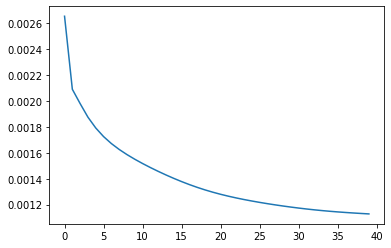

In [42]:
plt.plot(history.history['loss'])

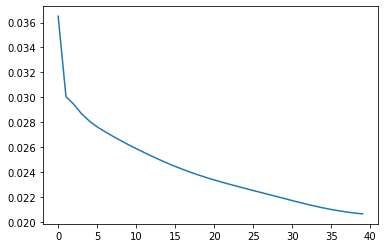

In [43]:
plt.plot(history.history['mean_absolute_error'])

In [44]:
y_err = np.abs(y_pred - y_test)

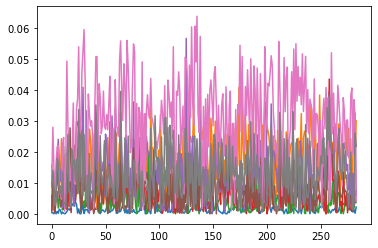

In [45]:
fig, ax = plt.subplots()
ax.plot(y_err)

## Save Model

In [50]:
model.save("all_channel_LSTM.h5")

In [51]:
!tensorflowjs_converter --input_format keras "all_channel_LSTM.h5" ./all_channel_LSTM_js

2020-11-14 11:06:05.812556: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'cudart64_101.dll'; dlerror: cudart64_101.dll not found
2020-11-14 11:06:05.812990: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


model:  
timesteps: 4  
feature 1: export => /100000 => NNmodel=> predicted value/100000  
feature 2: import => /100000 => NNmodel => predicted value/100000  
feature 3: WTI => difference => /100 => NNmodel => predicted difference/100  
feature 4: eastCoast => difference => NNmodel => predicted difference => +last price => predicted price  
feature 5: midwest => difference => NNmodel => predicted difference => +last price => predicted price  
feature 6: gulfCoast => difference => NNmodel => predicted difference => +last price => predicted price  
feature 7: rockyMountain => difference => NNmodel => predicted difference => +last price => predicted price  
feature 8: westCoast => difference => NNmodel => predicted difference => +last price => predicted price  